# Transformers for Sentiment Analysis

We're going to demonstrate how to use a pre-trained language model as the foundation for another model - for predicting the sentiment of a movie review (as positive or negative).

## Imports

We will lean heavily on our `modelling` package for handling the datasets, loading pre-trained models and adapting them to the classification task, for which we will also need to import PyTorch.

In [1]:
import math
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

from modelling import data, utils
from modelling import transformer as tfr

warnings.filterwarnings("ignore")

## Model and Training Parameters

Configure hyper-parameters for the model and the training routine.

In [2]:
MODEL_NAME = "decoder_next_word_gen"

MAX_EPOCHS = 10
BATCH_SIZE = 64
MIN_SEQ_LEN = 10
MAX_SEQ_LEN = 100
MIN_WORD_FREQ = 2
LEARNING_RATE = 0.0001

## Setup Training Data

We're tackling a supervised learning task, so we'll need (class) labels as well as features.

In [3]:
datasets = data.make_sentiment_datasets(
    min_seq_len=MIN_SEQ_LEN, max_seq_len=MAX_SEQ_LEN, min_tok_freq=MIN_WORD_FREQ
)

train_dl = DataLoader(
    datasets.train_data,
    batch_size=BATCH_SIZE,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

val_dl = DataLoader(
    datasets.val_data,
    batch_size=BATCH_SIZE,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

test_dl = DataLoader(
    datasets.test_data,
    batch_size=BATCH_SIZE,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

Let's take a quick look at one instance of this data.

In [4]:
tokenized_review, review_sentiment = next(iter(datasets.train_data))

print(f"x={tokenized_review[:5].tolist()}...")
print(f"y={review_sentiment.tolist()}")

x=[11, 232, 9193, 7, 64]...
y=[0.0]


It's pretty clear to see that our features are tokens and our label

In [5]:
pre_trained_model: tfr.NextWordPredictionTransformer = utils.load_model(MODEL_NAME)
pre_trained_model

loading .models/decoder_next_word_gen/trained@2023-10-11T03:57:36;loss=5_0740.pt


NextWordPredictionTransformer(
  (_position_encoder): PositionalEncoding(
    (_dropout): Dropout(p=0.1, inplace=False)
  )
  (_embedding): Embedding(69014, 256)
  (_decoder): TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=512, out_features=256, bias=True)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
    (dropout3): Dropout(p=0.1, inplace=Fal

## Adapt Pre-Trained Model to Create Document Embeddings

Recall that the pre-trained model was original trained to predict the next token in a sequence, which is ultimately a classification task that necessitated the final layer of the model being a linear layer that output the logits for all possible tokens (~30k). 

We need to remove this last layer and replace it with a layer that pools the context-aware embeddings and then transforms this aggregation into the logit for a binary classification task.

So, we define a new model (using inheritance) that will only initialise and use the layers of the pre-trained model that we want and then add-in the new components that we need.

In [6]:
class SentimentClassificationTransformer(tfr.NextWordPredictionTransformer):
    """Adapting a generative model to yield text embeddings."""

    def __init__(self, pre_trained_model: tfr.NextWordPredictionTransformer):
        super().__init__(
            pre_trained_model._size_vocab,
            pre_trained_model._size_embed,
            pre_trained_model._n_heads,
        )
        del self._linear
        self.load_state_dict(pre_trained_model.state_dict(), strict=False)
        self._logit = nn.Linear(pre_trained_model._size_embed, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_causal_mask, x_padding_mask = self._make_mask(x)
        out = self._embedding(x) * math.sqrt(torch.tensor(self._size_embed))
        out = self._position_encoder(out)
        out = self._decoder(
            out,
            out,
            tgt_mask=x_causal_mask,
            tgt_key_padding_mask=x_padding_mask,
            memory_mask=x_causal_mask,
            memory_key_padding_mask=x_padding_mask,
        )
        out = torch.max(out, dim=1).values
        out = F.sigmoid(self._logit(out))
        return out

Let's create an instance of our sentiment classification model and feed it a tokenised chunk of text to make sure that what we get back is the right shape and type for our new task.

In [7]:
sentiment_cls = SentimentClassificationTransformer(pre_trained_model)

class_logits = sentiment_cls(tokenized_review.view(1, -1))
class_logits

tensor([[0.5530]], grad_fn=<SigmoidBackward0>)

That's precisely what we're after!

## Fine-Tune the Model

Now we need a training loop to fine-tune our newly configured model to the classification task. This follows pretty much the same pattern that all of training loops have followed - we loop over batches of data computing gradients and updating parameters, using the model's performance on a validation dataset at the end of each epoch to decide wether or not to continue training.

In [8]:
def train(
    model: nn.Module,
    train_data: DataLoader,
    val_data: DataLoader,
    n_epochs: int,
    learning_rate: float = 0.0005,
    random_seed: int = 42,
) -> tuple[dict[int, float], dict[int, float]]:
    """Training loop for sentiment classification."""
    torch.manual_seed(random_seed)

    optimizer = Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.BCELoss()

    train_losses: dict[int, float] = {}
    val_losses: dict[int, float] = {}

    for epoch in range(1, n_epochs + 1):

        # loop over batches training model
        loss_train = torch.tensor(0.0)
        model.train()
        for i, (x_batch, y_batch) in enumerate((pbar := tqdm(train_data)), start=1):
            optimizer.zero_grad(set_to_none=True)
            y_pred = model(x_batch)
            loss_batch = loss_fn(y_pred, y_batch)
            loss_batch.backward()
            optimizer.step()
            loss_train += loss_batch
            pbar.set_description(f"epoch {epoch} training loss = {loss_train/i:.4f}")

        # score validation dataset after training ends
        loss_val = torch.tensor(0.0)
        model.eval()
        for x_batch, y_batch in val_data:
            y_pred = model(x_batch)
            loss_batch = loss_fn(y_pred, y_batch)
            loss_val += loss_batch

        # compute end of epoch metrics
        epoch_train_loss = loss_train.item() / len(train_data)
        epoch_val_loss = loss_val.item() / len(val_data)

        # if this is currently the best performing model, checkpoint parameters
        if epoch == 1 or epoch_val_loss < min(val_losses.values()):
            best_checkpoint = utils.ModelCheckpoint(
                epoch, epoch_train_loss, epoch_val_loss, model.state_dict().copy()
            )

        # persist end of epoch metrics
        train_losses[epoch] = epoch_train_loss
        val_losses[epoch] = epoch_val_loss

        # stop training if validation set losses have plateaued
        if utils._early_stop(val_losses):
            break

    # reload best model params and report performance
    model.load_state_dict(best_checkpoint.state_dict)
    print("\nbest model:")
    print(f"|-- epoch: {best_checkpoint.epoch}")
    print(f"|-- validation loss: {best_checkpoint.val_loss:.4f}")
    
    return train_losses, val_losses

Let's train this thing!

In [9]:
train_losses, val_losses, = train(
    sentiment_cls, train_dl, val_dl, MAX_EPOCHS, LEARNING_RATE
)

epoch 4 training loss = 0.2515: 100%|██████████| 666/666 [01:54<00:00,  5.80it/s]



best model:
|-- epoch: 2
|-- validation loss: 0.3841


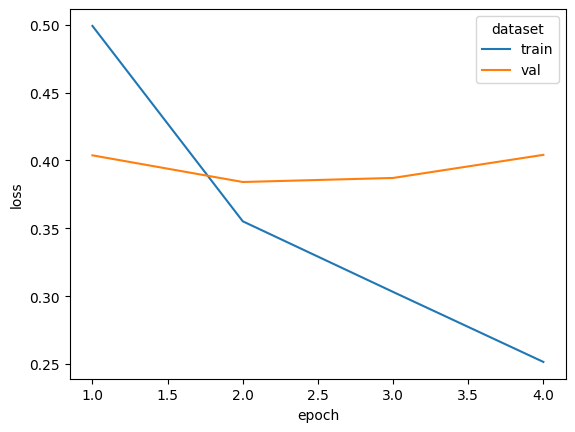

In [10]:
utils.plot_train_losses(train_losses, val_losses)

Note how quickly we were able to fine-tune our pre-trained model to adapt it to the new task - this is the power of LLMs in action.

## Evaluate Model on Test Dataset

Before we get too carried away, lets compute the model's performance on the test dataset.

In [11]:
hits = torch.tensor(0.0)
for x_batch, y_batch in test_dl:
    y_pred = sentiment_cls(x_batch)
    hits += torch.sum(y_pred.round() == y_batch)

accuracy = hits.item() / (BATCH_SIZE * len(test_dl))
print(f"accuracy = {accuracy:.1%}")

accuracy = 83.8%


Not bad!